# Try Reddit API

The goal is to understand the parameters and limitations of the api and check if it could be used to get crypto news programatically.

In [1]:
import os
os.chdir('../')

In [22]:
import praw
import yaml
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from settings import REDDIT_CREDS

## Import data

Get credentials.

In [3]:
# has to follow this rules: https://github.com/reddit-archive/reddit/wiki/API

client_name = "news_bot"
client_version = "0.1.0"
user_name = os.getenv('REDDIT_USERNAME')
client_id = os.getenv('REDDIT_CLIENT_ID')
client_secret = os.getenv('REDDIT_SECRET')

# Override if creds are in yaml file
if os.path.isfile(REDDIT_CREDS):
    with open(REDDIT_CREDS) as stream:
        creds = yaml.safe_load(stream)
    user_name = creds['REDDIT_USERNAME']
    client_id = creds['REDDIT_CLIENT_ID']
    client_secret = creds['REDDIT_SECRET']

In [4]:
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=f"praw:{client_name}:{client_version} (by /u/{user_name})",
)

In [5]:
print(reddit.read_only)

True


In [6]:
data_records = []
for submission in reddit.subreddit("CryptoCurrency").top("week", limit=None):
    data_records.append({
        'id': submission.id,
        'created_utc': time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(submission.created_utc)),
        'author': submission.author,
        'title': submission.title,
        'name': submission.name,
        'link_flair_text': submission.link_flair_text,
        'selftext': submission.selftext,
        'url': submission.url,
        'score': submission.score, 
        'upvote_ratio': submission.upvote_ratio,
        'distinguished': submission.distinguished,
    })

news_df = pd.DataFrame.from_records(data_records)
print(f"Submissions retrieved: {news_df.shape[0]}")

Submissions retrieved: 1000


In [7]:
news_df.head()

,id,created_utc,author,title,name,link_flair_text,selftext,url,score,upvote_ratio,distinguished
0,sode68,2022-02-09 13:17:52,Latespoon,Coinbase have stolen my Eth deposit and ignore...,t3_sode68,EXCHANGES,"I deposited ETH, from an address I have used m...",https://www.reddit.com/r/CryptoCurrency/commen...,13449,0.91,None
1,ss8ohv,2022-02-14 11:40:59,Blitzwarden,Hacker could’ve printed unlimited ‘Ether’ but ...,t3_ss8ohv,GENERAL-NEWS,,https://protos.com/ether-hacker-optimism-ether...,13026,0.92,None
2,srr32t,2022-02-13 19:44:18,RefugeeDutch_Syrian,'White Hat hacker' saves Coinbase from possibl...,t3_srr32t,GENERAL-NEWS,"In the nick of time, a gigantic crisis for the...",https://www.reddit.com/r/CryptoCurrency/commen...,9119,0.93,None
3,ssajk9,2022-02-14 13:25:03,Acceptable_Novel8200,"Snowden : Coinbase spending $16,000,000 on a S...",t3_ssajk9,EXCHANGES,Edward Snowden's tweet on Coinbase's superbowl...,https://www.reddit.com/r/CryptoCurrency/commen...,6232,0.96,None
4,sp71mt,2022-02-10 13:49:24,rmansd619,What its like currently holding ADA.,t3_sp71mt,COMEDY,Hodling ADA is like you're eating at a 5 star...,https://www.reddit.com/r/CryptoCurrency/commen...,6076,0.84,None


## Some statistics

### Score

<AxesSubplot:>

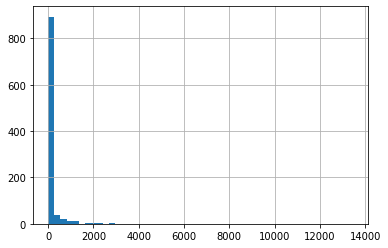

In [8]:
news_df.score.hist(bins=50)

In [9]:
news_df.score.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.0        4.0
0.1        7.0
0.2        8.0
0.3       10.0
0.4       14.0
0.5       19.0
0.6       27.0
0.7       50.0
0.8       97.0
0.9      297.3
1.0    13449.0
Name: score, dtype: float64

### Length of title
Number of characters.

<AxesSubplot:>

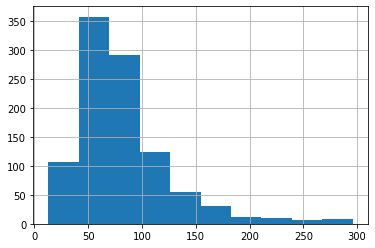

In [10]:
news_df.title.apply(len).hist()

### Length of selftext
Number of characters in **non-empty strings**.

<AxesSubplot:>

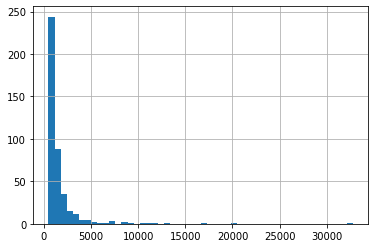

In [11]:
selftext_len = news_df.selftext.apply(len)
selftext_len[selftext_len > 0].hist(bins=50)

In [12]:
selftext_len[selftext_len > 0].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.0      482.0
0.1      568.8
0.2      668.6
0.3      776.8
0.4      871.6
0.5     1011.0
0.6     1157.8
0.7     1401.2
0.8     1869.8
0.9     2769.0
1.0    32759.0
Name: selftext, dtype: float64

## Clean data

Keep only articles with high scores.

In [13]:
news_df = news_df[news_df.score > 50].copy()

In [14]:
print(f"Submissions selected: {news_df.shape[0]}")

Submissions selected: 295


# Text classification

## Titles

Prepare list.

In [15]:
news_list = list(news_df.title)

Transform text to vectors.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(news_list)

K-means clustering.

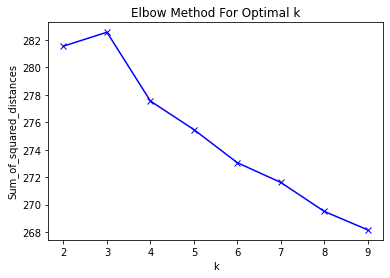

In [17]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [42]:
true_k = 4
km_model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
km_model.fit(X)
labels = km_model.labels_

news_df['cluster'] = labels
news_df.groupby('cluster').title.count()

cluster
0     74
1    114
2    100
3      7
Name: title, dtype: int64

Top words in each cluster.

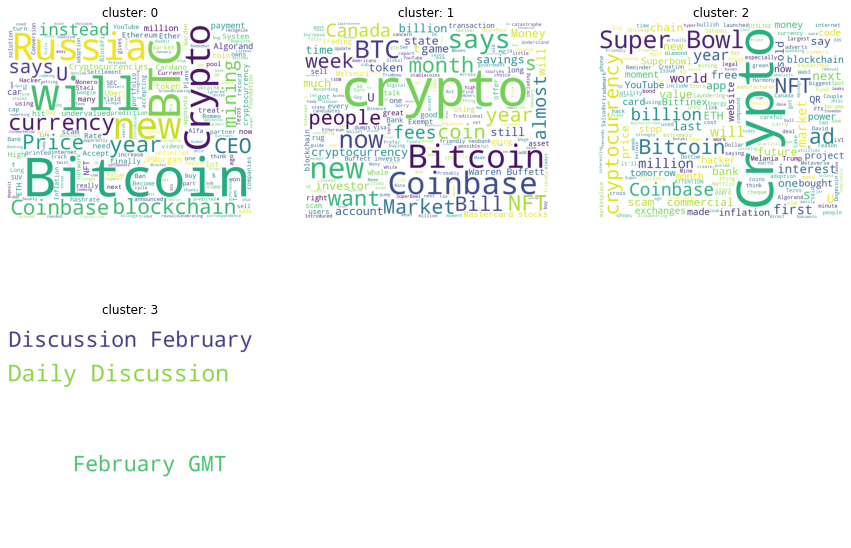

In [44]:
from wordcloud import WordCloud

# prepare subplots
clusters = list(news_df.cluster.unique())
plot_cols = 3
plot_rows = int(np.ceil(len(clusters) / plot_cols))
fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(15,10))

for cluster in clusters:
    col = cluster % plot_cols
    row = int(cluster/plot_cols)
    
    corpus = ' '.join(news_df['title'][news_df['cluster'] == cluster])
    ax[row,col].imshow(WordCloud(width = 1000,
                             height = 800,
                             background_color ='white', 
                             min_font_size = 10).generate(corpus))
    ax[row,col].set_title(f"cluster: {cluster}")
for axrow in ax:
    for axelm in axrow:
        axelm.axis("off")
    
plt.show()

**Reading recomendations:** Top submission in each cluster.

In [71]:
news_df['url'] = news_df['id'].apply(lambda s: f"http://redd.it/{s}")
print(news_df[['url', 'title', 'cluster', 'score']].sort_values(['cluster', 'score']).groupby('cluster').tail(1))

                       url                                              title  \
0    http://redd.it/sode68  Coinbase have stolen my Eth deposit and ignore...   
2    http://redd.it/srr32t  'White Hat hacker' saves Coinbase from possibl...   
3    http://redd.it/ssajk9  Snowden : Coinbase spending $16,000,000 on a S...   
131  http://redd.it/sorvwz       Daily Discussion - February 10, 2022 (GMT+0)   

     cluster  score  
0          0  13449  
2          1   9119  
3          2   6232  
131        3    187  


## Selftext

In [52]:
selftext_df = news_df[news_df.selftext.apply(len) > 0].copy()
selftext_df.shape

(147, 12)

Prepare list.

In [55]:
selftext_list = list(selftext_df.selftext)

147

Transform text to vectors.

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(selftext_list)

K-means clustering.

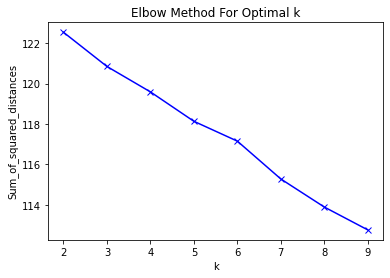

In [57]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [58]:
true_k = 5
km_model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
km_model.fit(X)
labels = km_model.labels_

selftext_df['cluster'] = labels
selftext_df.groupby('cluster').title.count()

cluster
0    11
1    21
2     7
3    98
4    10
Name: title, dtype: int64

Top words in each cluster.

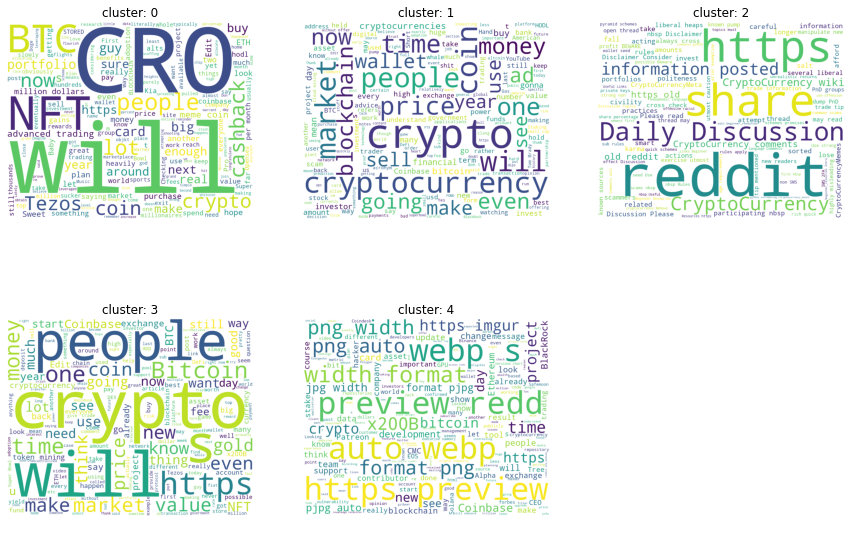

In [66]:
from wordcloud import WordCloud

# prepare subplots
clusters = list(selftext_df.cluster.unique())
plot_cols = 3
plot_rows = int(np.ceil(len(clusters) / plot_cols))
fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(15,10))

for cluster in clusters:
    col = cluster % plot_cols
    row = int(cluster/plot_cols)
    
    corpus = ' '.join(selftext_df['selftext'][selftext_df['cluster'] == cluster])
    ax[row,col].imshow(WordCloud(width = 1000,
                             height = 800,
                             background_color ='white', 
                             min_font_size = 10).generate(corpus))
    ax[row,col].set_title(f"cluster: {cluster}")
for axrow in ax:
    for axelm in axrow:
        axelm.axis("off")
    
plt.show()

**Reading recomendations:** Top submission in each cluster.

In [69]:
selftext_df['url'] = selftext_df['id'].apply(lambda s: f"http://redd.it/{s}")
print(selftext_df[['url', 'title', 'cluster', 'score']].sort_values(['cluster', 'score']).groupby('cluster').tail(1))

                       url                                              title  \
43   http://redd.it/soxt6k  Stop over leveraging your portfolio into CRO f...   
12   http://redd.it/sotn2r  Friendly Reminder: Be extra careful with new c...   
131  http://redd.it/sorvwz       Daily Discussion - February 10, 2022 (GMT+0)   
0    http://redd.it/sode68  Coinbase have stolen my Eth deposit and ignore...   
2    http://redd.it/srr32t  'White Hat hacker' saves Coinbase from possibl...   

     cluster  score  
43         0    881  
12         1   2804  
131        2    187  
0          3  13449  
2          4   9119  
